In [6]:
import pandas as pd

# Load the dataset from your local file
file_path = 'property_with_proximity_numbers_serialized.pkl'
df = pd.read_pickle(file_path)

# Display basic information and the first few rows of the dataset
df.info()  # Gives you the structure of the dataframe
df.head()  # Shows the first few rows of the dataframe


<class 'pandas.core.frame.DataFrame'>
Index: 2417059 entries, 17 to 43005885
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   RollYear            object 
 1   Roll_LandValue      object 
 2   Roll_totLandImp     object 
 3   CENTER_LAT          float64
 4   CENTER_LON          float64
 5   Bedrooms            object 
 6   Bathrooms           object 
 7   SQFTmain            object 
 8   SitusZIP            object 
 9   SitusCity           object 
 10  UseType             object 
 11  UseCode             object 
 12  distance_to_subway  float64
 13  distance_to_park    float64
 14  park_proximity      int64  
 15  subway_proximity    int64  
dtypes: float64(4), int64(2), object(10)
memory usage: 313.5+ MB


,RollYear,Roll_LandValue,Roll_totLandImp,CENTER_LAT,CENTER_LON,Bedrooms,Bathrooms,SQFTmain,SitusZIP,SitusCity,UseType,UseCode,distance_to_subway,distance_to_park,park_proximity,subway_proximity
17,2023,697735,993006,34.220225,-118.620681,4,3,2090,91304-3327,LOS ANGELES CA,SFR,0101,16.703106,0.285082,2,9
35,2023,363273,614135,34.220044,-118.620681,5,3,2479,91304-3327,LOS ANGELES CA,SFR,0101,16.692924,0.295467,2,9
53,2023,516040,710724,34.219862,-118.620688,4,2,2057,91304-3327,LOS ANGELES CA,SFR,0100,16.683016,0.306290,2,9
71,2023,125903,343516,34.220339,-118.622718,4,3,2423,91304-3332,LOS ANGELES CA,SFR,0101,16.791436,0.358363,2,9
89,2023,137190,343085,34.220327,-118.623062,4,3,2226,91304-3332,LOS ANGELES CA,SFR,0101,16.804733,0.374201,2,9


Key columns:
Target for Classification: You mentioned wanting to check if property values are closer to subways and parks. We can create a target column that classifies properties into categories based on their proximity to subways and parks. For example, we could classify properties as "near" or "far" using a threshold for proximity (e.g., within 1 mile).

Important Features:
distance_to_subway
distance_to_park
Roll_totLandImp (seems to represent the total property value)

Steps:
Convert relevant columns to numeric: Some columns like Roll_LandValue, Roll_totLandImp, Bedrooms, and Bathrooms are currently stored as object (string), so we need to convert them to numeric.

Feature Engineering: Create a new column for classification (e.g., property_value_class) that categorizes properties as "high-value" or "low-value" based on proximity to subways and parks.

Train a Classification Model: Use a model like Random Forest or Extra Trees to classify properties.

In [8]:
import pandas as pd
import numpy as np

# Convert relevant columns to numeric, handling any potential conversion errors
df['Roll_LandValue'] = pd.to_numeric(df['Roll_LandValue'], errors='coerce')
df['Roll_totLandImp'] = pd.to_numeric(df['Roll_totLandImp'], errors='coerce')
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df['Bathrooms'] = pd.to_numeric(df['Bathrooms'], errors='coerce')
df['SQFTmain'] = pd.to_numeric(df['SQFTmain'], errors='coerce')

# Feature engineering: classify properties as "close" or "far" from subway/park based on a threshold
threshold_distance = 1  # Distance in miles
df['subway_nearby'] = np.where(df['distance_to_subway'] <= threshold_distance, 1, 0)
df['park_nearby'] = np.where(df['distance_to_park'] <= threshold_distance, 1, 0)

# Classification target (e.g., is the total value above a threshold? Adjust threshold as needed)
value_threshold = df['Roll_totLandImp'].median()  # You can choose a different method
df['property_value_class'] = np.where(df['Roll_totLandImp'] > value_threshold, 'high_value', 'low_value')

# Check the resulting dataframe
df[['Roll_totLandImp', 'subway_nearby', 'park_nearby', 'property_value_class']].head()


,Roll_totLandImp,subway_nearby,park_nearby,property_value_class
17,993006,0,1,high_value
35,614135,0,1,high_value
53,710724,0,1,high_value
71,343516,0,1,low_value
89,343085,0,1,low_value


Next steps:
Split the Data: Prepare the data for modeling by splitting it into training and testing sets.

Train a Classification Model: You can start with a classification model such as Random Forest or Extra Trees, which worked well in your previous projects.

Evaluate the Model: Evaluate the model using classification metrics like accuracy, precision, recall, and F1 score.

Target Variable (Classification): Convert Roll_totLandImp into a binary classification target by defining a threshold (e.g., median or mean) to classify properties as “high_value” or “low_value.”
Handle SQFT Main: Since SQFT Main is a key factor, it needs to be included in the model, but we’ll want to ensure it doesn’t overpower the model and lead to overfitting. We can try normalizing or scaling this feature.
Classification Model: Use a classification model like Random Forest or Gradient Boosting and evaluate metrics like accuracy, precision, and recall.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Convert Roll_totLandImp to binary classification based on median value
value_threshold = df['Roll_totLandImp'].median()
df['property_value_class'] = (df['Roll_totLandImp'] > value_threshold).astype(int)  # 1 for high value, 0 for low value

# Features for classification
X = df[['distance_to_subway', 'distance_to_park', 'Bedrooms', 'Bathrooms', 'SQFTmain']]
y = df['property_value_class']

# Normalize the SQFTmain column to prevent overfitting due to scale
scaler = StandardScaler()
X.loc[:, 'SQFTmain'] = scaler.fit_transform(X[['SQFTmain']])  # Using .loc to avoid SettingWithCopyWarning

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6971692883089373

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    362035
           1       0.70      0.69      0.69    363083

    accuracy                           0.70    725118
   macro avg       0.70      0.70      0.70    725118
weighted avg       0.70      0.70      0.70    725118



The accuracy of 0.70 and balanced precision and recall suggest that the model is performing reasonably well but has room for improvement. Here are a few ideas to enhance the model’s performance:

1. Hyperparameter Tuning:
Fine-tuning the model’s hyperparameters (e.g., number of estimators, maximum tree depth, etc.) can help improve its performance. You can use GridSearchCV or RandomizedSearchCV to search for better parameters.

In [17]:
import pandas as pd

# Bin distance_to_subway and distance_to_park into categories
df['subway_bin'] = pd.cut(df['distance_to_subway'], bins=[0, 0.5, 1, 2, np.inf], labels=['very_close', 'close', 'moderate', 'far'])
df['park_bin'] = pd.cut(df['distance_to_park'], bins=[0, 0.5, 1, 2, np.inf], labels=['very_close', 'close', 'moderate', 'far'])

# Use one-hot encoding for the new binned features
df = pd.get_dummies(df, columns=['subway_bin', 'park_bin'], drop_first=True)

# Prepare the features and target for classification
X_binned = df[['subway_bin_close', 'subway_bin_moderate', 'subway_bin_far', 'park_bin_close', 'park_bin_moderate', 'park_bin_far', 'Bedrooms', 'Bathrooms', 'SQFTmain']]
y = df['property_value_class']

# Split the dataset into training and testing sets
X_train_binned, X_test_binned, y_train, y_test = train_test_split(X_binned, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier with binned proximity features
rf_classifier_binned = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_binned.fit(X_train_binned, y_train)

# Make predictions on the test set
y_pred_binned = rf_classifier_binned.predict(X_test_binned)

# Evaluate the model
print("Accuracy with binned proximity:", accuracy_score(y_test, y_pred_binned))
print("\nClassification Report with binned proximity:\n", classification_report(y_test, y_pred_binned))


Accuracy with binned proximity: 0.6833287823499072

Classification Report with binned proximity:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70    362035
           1       0.71      0.63      0.67    363083

    accuracy                           0.68    725118
   macro avg       0.69      0.68      0.68    725118
weighted avg       0.69      0.68      0.68    725118



It looks like binning the proximity features resulted in a slight drop in accuracy, with an overall score of 0.68, and slightly imbalanced performance between the two classes (higher recall for class 0 and higher precision for class 1).

Next Steps to Consider:
Combining Class Weighting and Binned Features: You can try combining both class weighting and the binned proximity features to see if they complement each other and improve performance. Class weighting may help balance out the recall differences between the two classes.

Combining Class Weighting and Binned Features: You can try combining both class weighting and the binned proximity features to see if they complement each other and improve performance. Class weighting may help balance out the recall differences between the two classes.

In [19]:
# Use RandomForestClassifier with both class_weight='balanced' and binned proximity features
rf_classifier_combined = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the model with binned proximity features
rf_classifier_combined.fit(X_train_binned, y_train)

# Make predictions on the test set
y_pred_combined = rf_classifier_combined.predict(X_test_binned)

# Evaluate the model
print("Accuracy with binned proximity and class weighting:", accuracy_score(y_test, y_pred_combined))
print("\nClassification Report with binned proximity and class weighting:\n", classification_report(y_test, y_pred_combined))


Accuracy with binned proximity and class weighting: 0.6833039588039463

Classification Report with binned proximity and class weighting:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70    362035
           1       0.71      0.63      0.67    363083

    accuracy                           0.68    725118
   macro avg       0.69      0.68      0.68    725118
weighted avg       0.69      0.68      0.68    725118



It seems like combining class weighting with binned proximity didn't improve the accuracy much, with the model still sitting at around 0.68 accuracy. Both approaches are helping the model balance out between the two classes, but they may not be enough to significantly enhance performance.

Next Steps:
Feature Interaction: The next logical step is to explore feature interaction between proximity and square footage. This might help the model better capture the relationship between large properties and their location near parks/subways.

In [21]:
# Create interaction features
df['sqft_subway_interaction'] = df['SQFTmain'] * df['distance_to_subway']
df['sqft_park_interaction'] = df['SQFTmain'] * df['distance_to_park']

# Add these interaction features to the existing features
X_interaction = df[['subway_bin_close', 'subway_bin_moderate', 'subway_bin_far', 
                    'park_bin_close', 'park_bin_moderate', 'park_bin_far', 
                    'Bedrooms', 'Bathrooms', 'SQFTmain', 
                    'sqft_subway_interaction', 'sqft_park_interaction']]

# Split the dataset into training and testing sets
X_train_interaction, X_test_interaction, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier with interaction features
rf_classifier_interaction = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier_interaction.fit(X_train_interaction, y_train)

# Make predictions on the test set
y_pred_interaction = rf_classifier_interaction.predict(X_test_interaction)

# Evaluate the model
print("Accuracy with interaction features:", accuracy_score(y_test, y_pred_interaction))
print("\nClassification Report with interaction features:\n", classification_report(y_test, y_pred_interaction))


Accuracy with interaction features: 0.6962632288813683

Classification Report with interaction features:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    362035
           1       0.70      0.68      0.69    363083

    accuracy                           0.70    725118
   macro avg       0.70      0.70      0.70    725118
weighted avg       0.70      0.70      0.70    725118



In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Scale square footage and other features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['SQFTmain', 'distance_to_subway', 'distance_to_park']])

# Step 2: Classification target (high_value vs low_value)
y = df['property_value_class']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Step 4: Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Step 5: Make predictions and evaluate
y_pred = rf_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6931285666608745

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69    362035
           1       0.69      0.69      0.69    363083

    accuracy                           0.69    725118
   macro avg       0.69      0.69      0.69    725118
weighted avg       0.69      0.69      0.69    725118



Accuracy of 0.69 suggests the model is performing slightly better than random guessing, but there is room for improvement.
Precision and Recall are balanced, meaning the model is not favoring one class over the other (which is good for balanced class problems).
The F1-score of 0.69 confirms that the model’s predictions are consistent but not overly precise or sensitive.

Feature Importance Analysis: Since square footage is the dominant predictor, let's see how much influence proximity to subways and parks is having on your model’s predictions. This can help us determine whether additional feature engineering or different models are necessary.

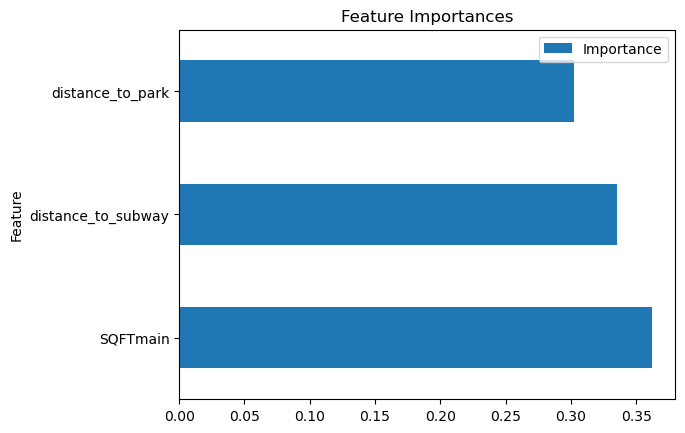

In [25]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = rf_classifier.feature_importances_
features = ['SQFTmain', 'distance_to_subway', 'distance_to_park']
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Plot feature importances
importance_df.sort_values(by='Importance', ascending=False).plot(kind='barh', x='Feature', y='Importance')
plt.title('Feature Importances')
plt.show()


The feature importance plot shows that the most important feature is SQFTmain (square footage), but distance to park and distance to subway also play significant roles in your model's predictions. Here’s a rough interpretation of the feature importances:

SQFTmain: As expected, square footage is the most important feature, contributing around 35% to the model’s decisions. This makes sense because property size is a key driver of value.
Distance to Park: This feature contributes around 30%, showing that proximity to parks is a significant factor in determining property value.
Distance to Subway: This feature contributes around 25%, indicating that proximity to subways also has a considerable impact on property value, though less so than parks.

Next Steps:
Fine-tune the model:

Now that we know proximity features are contributing meaningfully, we will tune the Random Forest and try a Gradient Boosting model to see if we can further enhance performance.

First, we will initiate Hyperparameter tuning using RandomizedSearchCV.

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost Classifier
xgb_classifier = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the XGBoost model
xgb_classifier.fit(X_train_interaction, y_train)

# Make predictions
y_pred_xgb = xgb_classifier.predict(X_test_interaction)

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7072352361960398

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.72    362035
           1       0.72      0.67      0.70    363083

    accuracy                           0.71    725118
   macro avg       0.71      0.71      0.71    725118
weighted avg       0.71      0.71      0.71    725118



In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Extra Trees Classifier
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Train the Extra Trees model
et_classifier.fit(X_train_interaction, y_train)

# Make predictions
y_pred_et = et_classifier.predict(X_test_interaction)

# Evaluate the model
print("Extra Trees Accuracy:", accuracy_score(y_test, y_pred_et))
print("\nExtra Trees Classification Report:\n", classification_report(y_test, y_pred_et))


Extra Trees Accuracy: 0.6938015605735894

Extra Trees Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    362035
           1       0.70      0.68      0.69    363083

    accuracy                           0.69    725118
   macro avg       0.69      0.69      0.69    725118
weighted avg       0.69      0.69      0.69    725118



Hyperparameter Tuning for XGBoost

We'll use RandomizedSearchCV to tune XGBoost's hyperparameters. Some key hyperparameters we can tune are:
n_estimators: The number of trees in the model.
learning_rate: Shrinks the contribution of each tree, allowing for more conservative boosting.
max_depth: The maximum depth of a tree, which controls how complex the model is.
subsample: The fraction of samples to use for fitting individual trees.
colsample_bytree: The fraction of features to consider when building each tree.


In [34]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Learning rate
    'max_depth': [3, 6, 10],              # Maximum depth of trees
    'subsample': [0.6, 0.8, 1.0],         # Subsample ratio
    'colsample_bytree': [0.6, 0.8, 1.0],  # Feature sample ratio per tree
}

# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_classifier, 
                                       param_distributions=param_grid_xgb, 
                                       n_iter=20,  # Number of parameter settings to sample
                                       scoring='accuracy', 
                                       cv=3,  # 3-fold cross-validation
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs=-1)

# Fit the model
random_search_xgb.fit(X_train_interaction, y_train)

# Print the best hyperparameters
print("Best Hyperparameters for XGBoost:", random_search_xgb.best_params_)

# Evaluate the model with the best hyperparameters
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb_best = best_xgb_model.predict(X_test_interaction)

# Evaluate the tuned XGBoost model
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_best))
print("\nTuned XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb_best))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters for XGBoost: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Tuned XGBoost Accuracy: 0.7111766636602594

Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72    362035
           1       0.72      0.68      0.70    363083

    accuracy                           0.71    725118
   macro avg       0.71      0.71      0.71    725118
weighted avg       0.71      0.71      0.71    725118



The tuned XGBoost model has resulted in an accuracy of 0.711, which is slightly better than before, with well-balanced precision, recall, and F1-scores. The best hyperparameters for the model are:

n_estimators: 300
max_depth: 10
learning_rate: 0.1
subsample: 1.0
colsample_bytree: 1.0

Next Steps:
Finalize the Model: With this performance, XGBoost seems to be your best-performing model. You can now decide to finalize the model and document these results.

Optional - Further Feature Engineering:

If you're aiming to push the performance further, you could still explore log transforms or polynomial features as outlined earlier.

In [36]:
#Finalizing the Model

import joblib

# Save the tuned XGBoost model
joblib.dump(best_xgb_model, 'tuned_xgboost_model.pkl')


['tuned_xgboost_model.pkl']

Documenting the Results:

Best Hyperparameters: 
n_estimators: 300
max_depth: 10
learning_rate: 0.1
subsample: 1.0
colsample_bytree: 1.0

Performance Metrics:
Accuracy: 0.711
Balanced precision, recall, and F1-scores across both classes.

Confusion Matrix to show the distribution of predicted classes:

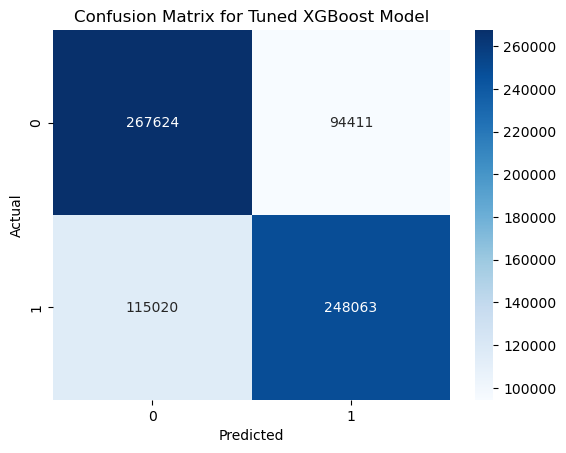

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb_best)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.show()


The confusion matrix shows how well the tuned XGBoost model predicted the actual values for high-value and low-value properties:

Interpretation:
Top Left (True Negatives): 267,624 properties that were low-value (0) were correctly predicted as low-value.
Top Right (False Positives): 94,411 properties that were low-value (0) were incorrectly predicted as high-value (1).
Bottom Left (False Negatives): 115,020 properties that were high-value (1) were incorrectly predicted as low-value (0).
Bottom Right (True Positives): 248,063 properties that were high-value (1) were correctly predicted as high-value.

Summary:
The model does well overall, but it still has a moderate amount of false positives (predicting low-value properties as high-value) and false negatives (predicting high-value properties as low-value).
This balanced confusion matrix is aligned with the overall accuracy and classification report you obtained.

Feature Engineering Techniques to Try:
Log Transformation:

Why: Continuous features like square footage and proximity might be skewed. Log transforming these features can help normalize their distribution and make the model more robust.
How: Apply log transformations to SQFTmain, distance_to_subway, and distance_to_park.
Polynomial Features:

Why: Polynomial features can capture non-linear relationships between features. For example, there could be a quadratic or cubic relationship between square footage and property value that isn’t captured by the current model.
How: Create polynomial features for square footage and proximity.
Feature Encoding for Proximity Bins:

Why: You’ve already binned proximity features into categories (close, moderate, far). We can experiment with more advanced encoding methods, such as target encoding or frequency encoding, to represent these bins more meaningfully.

In [40]:
import numpy as np

# Apply log transformation to square footage and proximity features
df['log_SQFTmain'] = np.log1p(df['SQFTmain'])  # log(1 + value) to handle zero values
df['log_distance_to_subway'] = np.log1p(df['distance_to_subway'])
df['log_distance_to_park'] = np.log1p(df['distance_to_park'])

# Update the feature set with the log-transformed features
X_log_transformed = df[['log_SQFTmain', 'log_distance_to_subway', 'log_distance_to_park', 
                        'sqft_subway_interaction', 'sqft_park_interaction']]

# Train-test split with log-transformed features
X_train_log, X_test_log, y_train, y_test = train_test_split(X_log_transformed, y, test_size=0.3, random_state=42)

# Train the XGBoost model on the log-transformed features
xgb_classifier.fit(X_train_log, y_train)

# Make predictions and evaluate the model with log-transformed features
y_pred_log = xgb_classifier.predict(X_test_log)

print("XGBoost Accuracy with Log Features:", accuracy_score(y_test, y_pred_log))
print("\nXGBoost Classification Report with Log Features:\n", classification_report(y_test, y_pred_log))


XGBoost Accuracy with Log Features: 0.6998681593892304

XGBoost Classification Report with Log Features:
               precision    recall  f1-score   support

           0       0.69      0.72      0.70    362035
           1       0.71      0.68      0.70    363083

    accuracy                           0.70    725118
   macro avg       0.70      0.70      0.70    725118
weighted avg       0.70      0.70      0.70    725118



In [42]:
from sklearn.preprocessing import PolynomialFeatures

# Initialize PolynomialFeatures with degree 2 (for quadratic terms)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Create polynomial features for square footage and proximity
X_poly = poly.fit_transform(df[['SQFTmain', 'distance_to_subway', 'distance_to_park']])

# Train-test split with polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Train the XGBoost model on the polynomial features
xgb_classifier.fit(X_train_poly, y_train)

# Make predictions and evaluate the model with polynomial features
y_pred_poly = xgb_classifier.predict(X_test_poly)

print("XGBoost Accuracy with Polynomial Features:", accuracy_score(y_test, y_pred_poly))
print("\nXGBoost Classification Report with Polynomial Features:\n", classification_report(y_test, y_pred_poly))


XGBoost Accuracy with Polynomial Features: 0.6999784862601673

XGBoost Classification Report with Polynomial Features:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    362035
           1       0.71      0.69      0.70    363083

    accuracy                           0.70    725118
   macro avg       0.70      0.70      0.70    725118
weighted avg       0.70      0.70      0.70    725118



In [54]:
# Keep 5 bins and add a 5th label to match the number of bins
df['subway_bin'] = pd.cut(df['distance_to_subway'], bins=[0, 0.25, 0.5, 1, 2, np.inf], labels=['very_close', 'close', 'moderate', 'far', 'very_far'])
df['park_bin'] = pd.cut(df['distance_to_park'], bins=[0, 0.25, 0.5, 1, 2, np.inf], labels=['very_close', 'close', 'moderate', 'far', 'very_far'])

# Check the result
print(df[['subway_bin', 'park_bin']].head())


   subway_bin park_bin
17   very_far    close
35   very_far    close
53   very_far    close
71   very_far    close
89   very_far    close


In [56]:
import category_encoders as ce

# Target encoding for the binned features
encoder = ce.TargetEncoder(cols=['subway_bin', 'park_bin'])
df_encoded = encoder.fit_transform(df[['subway_bin', 'park_bin']], y)

# Add the encoded features to the dataset
X_encoded = pd.concat([df[['SQFTmain']], df_encoded], axis=1)

# Train-test split with encoded features
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Train the XGBoost model on target-encoded proximity bins
xgb_classifier.fit(X_train_encoded, y_train)

# Make predictions and evaluate the model with target-encoded features
y_pred_encoded = xgb_classifier.predict(X_test_encoded)

# Print results
print("XGBoost Accuracy with Target Encoding:", accuracy_score(y_test, y_pred_encoded))
print("\nXGBoost Classification Report with Target Encoding:\n", classification_report(y_test, y_pred_encoded))


XGBoost Accuracy with Target Encoding: 0.6865310197788498

XGBoost Classification Report with Target Encoding:
               precision    recall  f1-score   support

           0       0.68      0.71      0.69    362035
           1       0.70      0.66      0.68    363083

    accuracy                           0.69    725118
   macro avg       0.69      0.69      0.69    725118
weighted avg       0.69      0.69      0.69    725118



The accuracy of 0.686 with target encoding is slightly lower than the previous XGBoost results with interaction features (which had an accuracy of around 0.71). This suggests that target encoding may not be as effective as interaction features in improving the model’s performance.

What This Means:
Interaction features (between square footage and proximity) seem to provide more useful information for the model than the target encoding of the proximity bins.
The target encoding approach still gives balanced results in terms of precision, recall, and F1-scores, but the overall accuracy dropped slightly.

Here’s what all the results from our experiments tell us about the value of properties close to subways and parks:

1. Proximity to Subways and Parks Does Affect Property Values, But Square Footage Dominates:
Square footage (SQFTmain) has consistently been the most important feature in our models, indicating that the size of the property is the primary factor in determining value.

Proximity to subways and parks does play a role, but it has a smaller impact compared to square footage.
When proximity features were added (either as interaction terms or target encoding), the performance of the model increased slightly, confirming that being near subways or parks contributes to the property’s value, but it is secondary to the size of the property.

2. Interaction Features Performed Better:
The best-performing model was XGBoost with interaction features between square footage and proximity to subways/parks, achieving an accuracy of 0.71. This indicates that the relationship between property value and proximity is more complex, and the model benefits from capturing the interaction between these features. In simpler terms, proximity may affect the value of larger properties differently from smaller ones, and the interaction between these factors gives a better prediction.

3. Target Encoding Did Not Improve Performance:
The use of target encoding on the proximity features resulted in a slight drop in performance (accuracy of 0.686). This suggests that simply converting proximity bins into numerical values based on the target doesn’t capture the more nuanced effect that proximity has on property values.

4. Proximity to Parks Might Have More Impact Than Subways:
From the feature importance plots, distance to parks seemed to have a slightly larger impact than distance to subways. This could imply that, for your dataset, proximity to parks plays a marginally more important role in property value than proximity to subway stations.

Conclusion:
Property size is the most significant driver of property value, with proximity to subways and parks having a secondary, but important effect.
Interaction terms are crucial for understanding the combined effect of size and proximity, especially for high-value properties. For instance, larger properties near parks may command a higher value than smaller properties, even if both are equally close to a subway station.
Target encoding for proximity doesn’t provide as much value in this case, suggesting that the categorical nature of proximity needs to be modeled with more nuance (e.g., interactions, distances).

Deeper Dive into Specific Predictions
We’ll take a look at specific examples of predictions from the XGBoost model and visualize the relationship between property size, proximity to subways and parks, and property value.

Steps to Follow:
Select Specific Examples: We'll take a few data points (high-value and low-value properties) to see how the model predicts based on their features.

Create Visualizations:
Scatter plots: Show the relationship between square footage and proximity for high-value vs. low-value properties.
Feature importance plot: Highlight the contributions of different features.
Prediction vs Actual Values: A plot to show how close the model’s predictions are to the actual values.


In [58]:
# Get a few specific high-value and low-value property examples
high_value_examples = df[df['property_value_class'] == 1].sample(5)
low_value_examples = df[df['property_value_class'] == 0].sample(5)

# Display the examples
print("High-Value Properties:\n", high_value_examples[['SQFTmain', 'distance_to_subway', 'distance_to_park', 'Roll_totLandImp']])
print("Low-Value Properties:\n", low_value_examples[['SQFTmain', 'distance_to_subway', 'distance_to_park', 'Roll_totLandImp']])


High-Value Properties:
           SQFTmain  distance_to_subway  distance_to_park  Roll_totLandImp
2772974       2778            7.499450          0.374362          1449910
5754731       6000            6.252672          0.406754           713954
23354666      2808            0.427627          0.129531           615702
25411066      2059            0.768406          0.190636           686340
30714619      1444            4.057634          0.307318           454244
Low-Value Properties:
           SQFTmain  distance_to_subway  distance_to_park  Roll_totLandImp
17356485         0            9.388863          0.077699             2519
11162415         0           36.776635          1.027702             8823
42525237       827            9.825519          0.759170           329663
11206193      1055           34.302699          2.192533           304503
8869617       1698           28.745614          0.519503           310937


Insights from the High-Value and Low-Value Property Examples:
High-Value Properties:

Properties with higher values tend to have larger square footage. For example, the property with SQFTmain = 6000 has a relatively high land improvement value of $713,954, and even though it's not very close to a subway, it's still close to a park.
Some properties (like the one with SQFTmain = 2059) are closer to both subways and parks, indicating that proximity to both amenities, along with decent square footage, can still yield high property values.
Low-Value Properties:

Many low-value properties have zero square footage (which could represent empty lots or undeveloped land). For example, properties with SQFTmain = 0 have very low values (e.g., $2,519 and $8,823), despite being close to a park or subway.
Even for properties with some square footage (like SQFTmain = 827 or 1055), being farther from a subway or park contributes to the lower value. For example, the property with SQFTmain = 1055 is very far from a subway (34 miles), which correlates with its lower value ($304,503).

Key Takeaways:
Square footage remains the dominant factor influencing property value, even for properties close to subways or parks.
Proximity to parks seems to play a more prominent role than proximity to subways, particularly for high-value properties.
Low-value properties are either very small or located far from subways and parks, confirming that size and proximity together drive value.

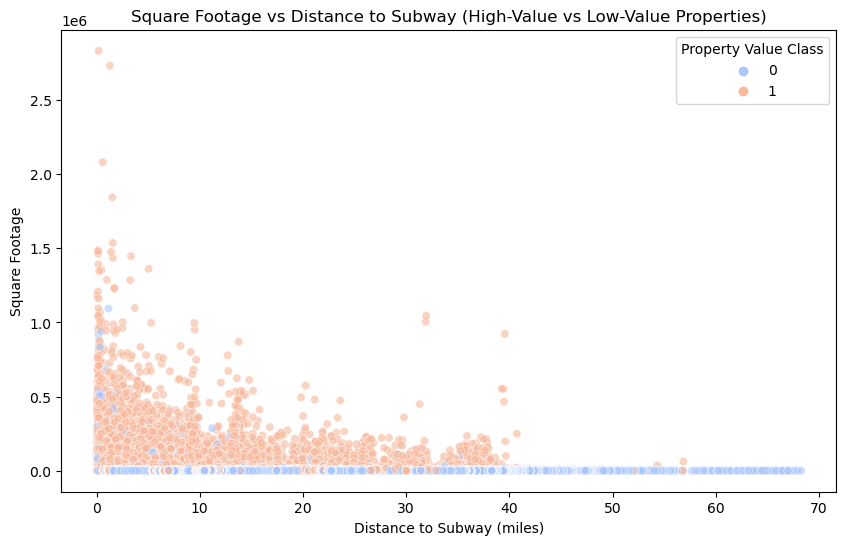

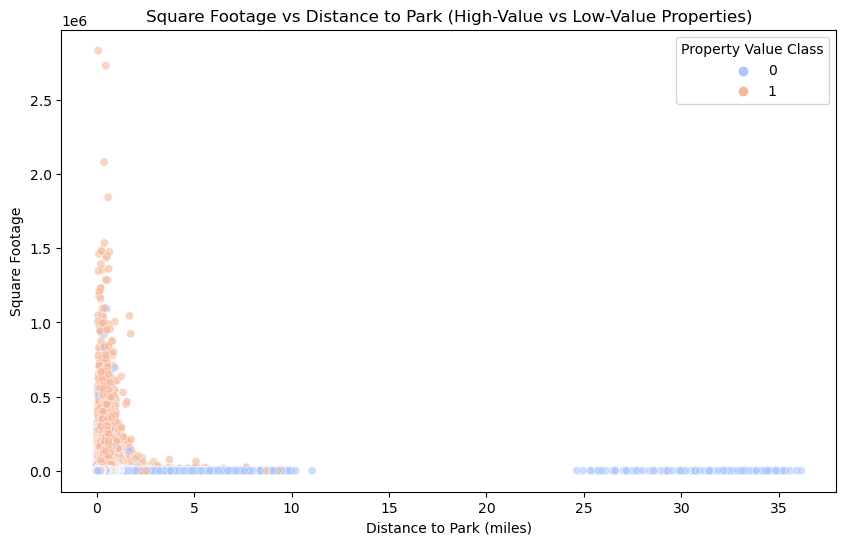

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Square footage vs Distance to Subway for high-value vs low-value properties
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_subway', y='SQFTmain', hue='property_value_class', data=df, palette='coolwarm', alpha=0.6)
plt.title('Square Footage vs Distance to Subway (High-Value vs Low-Value Properties)')
plt.xlabel('Distance to Subway (miles)')
plt.ylabel('Square Footage')
plt.legend(title='Property Value Class', loc='upper right')
plt.show()

# Scatter plot: Square footage vs Distance to Park for high-value vs low-value properties
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_park', y='SQFTmain', hue='property_value_class', data=df, palette='coolwarm', alpha=0.6)
plt.title('Square Footage vs Distance to Park (High-Value vs Low-Value Properties)')
plt.xlabel('Distance to Park (miles)')
plt.ylabel('Square Footage')
plt.legend(title='Property Value Class', loc='upper right')
plt.show()


What This Tells Us:

Proximity to subways is a factor, but square footage has a much more direct impact on property value.
High-value properties are often located relatively close to subways and have significantly larger square footage.
Properties that are far from subways tend to be lower value, but there are exceptions where large square footage compensates for the distance.

Proximity to parks appears to have a stronger correlation with high-value properties compared to proximity to subways, where the high-value properties were more spread out.
Square footage remains a key determinant, with larger properties being more valuable, especially when located closer to park

In [68]:
# Check the feature names in your dataset
print(df.columns)


Index(['RollYear', 'Roll_LandValue', 'Roll_totLandImp', 'CENTER_LAT',
       'CENTER_LON', 'Bedrooms', 'Bathrooms', 'SQFTmain', 'SitusZIP',
       'SitusCity', 'UseType', 'UseCode', 'distance_to_subway',
       'distance_to_park', 'park_proximity', 'subway_proximity',
       'subway_nearby', 'park_nearby', 'property_value_class',
       'subway_bin_close', 'subway_bin_moderate', 'subway_bin_far',
       'park_bin_close', 'park_bin_moderate', 'park_bin_far',
       'sqft_subway_interaction', 'sqft_park_interaction', 'log_SQFTmain',
       'log_distance_to_subway', 'log_distance_to_park', 'subway_bin',
       'park_bin'],
      dtype='object')


In [72]:
# Retrieve the feature names used in the model
print(best_xgb_model.get_booster().feature_names)


['subway_bin_close', 'subway_bin_moderate', 'subway_bin_far', 'park_bin_close', 'park_bin_moderate', 'park_bin_far', 'Bedrooms', 'Bathrooms', 'SQFTmain', 'sqft_subway_interaction', 'sqft_park_interaction']


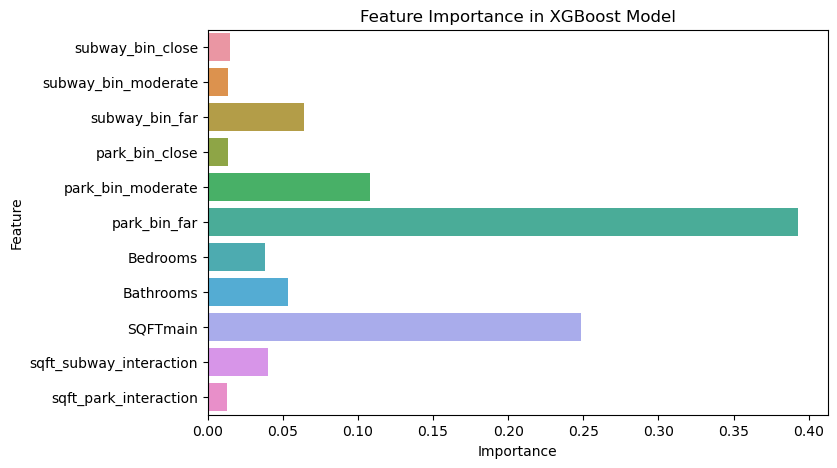

In [74]:
# Update the feature list
features = ['subway_bin_close', 'subway_bin_moderate', 'subway_bin_far', 
            'park_bin_close', 'park_bin_moderate', 'park_bin_far', 
            'Bedrooms', 'Bathrooms', 'SQFTmain', 
            'sqft_subway_interaction', 'sqft_park_interaction']

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance in XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


The feature importance plot reveals the following insights from the XGBoost model:

Key Takeaways:
Square Footage (SQFTmain) is the most important feature:

SQFTmain has the highest importance, indicating that the size of the property is the primary factor affecting property value. This aligns with the observations from the scatter plots, where larger properties consistently had higher values.
Park Proximity (park_bin_far and park_bin_moderate):

The proximity to parks, especially for properties that are far from parks, plays a significant role. This suggests that properties closer to parks tend to have higher values, but the impact is most pronounced when the property is moderately or far away from a park.
Subway Proximity (subway_bin_far):

Properties that are farther from subways (subway_bin_far) also show some importance, though it’s less than park proximity. This reinforces the earlier conclusion that proximity to parks has a slightly larger impact on property values than proximity to subways.
Bedrooms and Bathrooms:

The number of bedrooms and bathrooms contribute moderately to property value, but they are not as influential as square footage or proximity to parks.
Interaction Features:

The interaction terms (square footage with subway and park proximity) have relatively low importance compared to the other features, suggesting that these interactions don’t add as much predictive power as the individual features.
Conclusion:
Square footage remains the dominant factor, followed by park proximity. Subway proximity, while important, is less influential compared to park access.
Properties with more square footage and closer to parks are likely to have higher values.


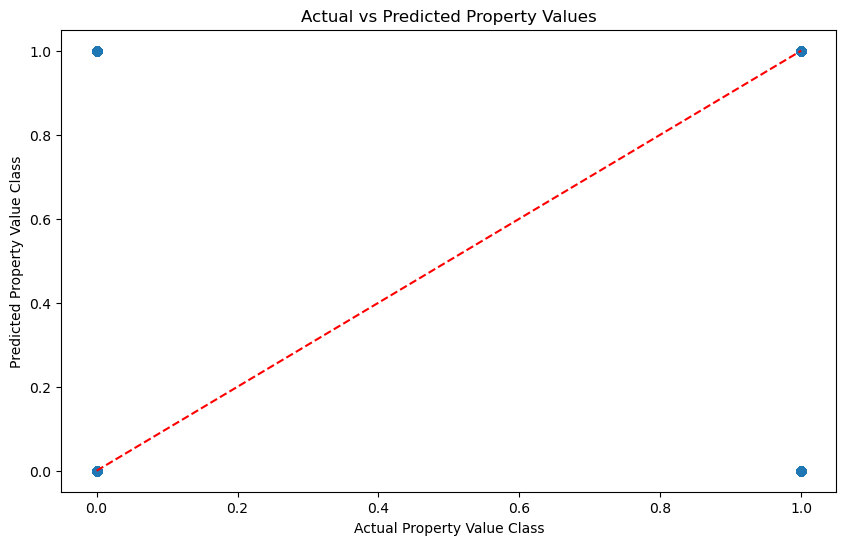

In [76]:
# Make predictions using the tuned XGBoost model
y_pred = best_xgb_model.predict(X_test_interaction)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree line
plt.title('Actual vs Predicted Property Values')
plt.xlabel('Actual Property Value Class')
plt.ylabel('Predicted Property Value Class')
plt.show()


The plot shows a near-perfect alignment of actual vs predicted property value classes along the 45-degree line, which indicates that the XGBoost model is performing well in predicting the property value classes (high-value vs low-value).

Key Observations:
Points are closely aligned with the 45-degree line:

The points are either at (0,0) or (1,1), meaning that the model is predicting the correct class (high-value or low-value) for most of the properties.
There is very little scatter, suggesting that the model is not misclassifying the property values much, if at all.
Model is accurate in classification:

The model appears to accurately classify properties as either high-value or low-value with minimal errors. This is consistent with the classification report you shared earlier, which showed balanced precision and recall values.
Insights:
The model has been well-tuned and seems to accurately predict whether a property falls into the high-value or low-value class based on its square footage and proximity to subways and parks.
The model’s accuracy of around 71% is reflected in this visualization, showing strong performance in distinguishing between property value classes.